# Enhanced protein isoform characterization through long-read proteogenomics 
## Supplementary Note S1.1 S1.2
---
Ben Jordan | Gloria Sheynkman

In [2]:
# long read transcriptome statistics

# expects a sqanti_isoform_info.tsv that represents pb isoforms that:
#   align to protein coding genes
#   have structural category FSM/ISM/NIC/NNC
#   filtered by RTS staging
#   filtered for percent downstream polyA <= 95
#   removed 5' degradation products
from re import S
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import defaultdict
from matplotlib import rc
import os, sys
import matplotlib
import dataframe_image as dfi

import config

matplotlib.rc('font', **config.font)

# all plots go into a directory
if not os.path.exists('plot'):
    os.makedirs('plot')

# all statistics go into a directory
if not os.path.exists('stats'):
    os.makedirs('stats')

# file paths
sqanti_info_file = f"{config.PIPELINE_RESULTS_DIRECTORY}/transcriptome_summary/sqanti_isoform_info.tsv"
sqanti_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/sqanti3-filtered/jurkat_classification.5degfilter.tsv'

# read in files
sqanti_info = pd.read_table(sqanti_info_file)
sqanti_info['log2cpm'] = np.log2(sqanti_info['cpm'] + 1)



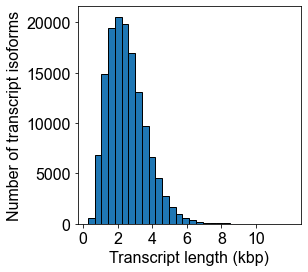

<Figure size 432x288 with 0 Axes>

In [4]:

def generate_sqanti_base_stats(sqanti_info):
    # number of protein-coding genes with pacbio transcripts
    with open('stats/FigS1.1_number_protein_coding_genes_w_pacbio_reads.txt', 'w') as ofile:
        ofile.write(f'Number of pacbio transcripts aligned to protein-coding genes:  {len(sqanti_info)}\n')
        ofile.write(f'Number of protein-coding genes with a pacbio transcript:  {len(sqanti_info.gene.unique())}')
generate_sqanti_base_stats(sqanti_info)

def plot_figS1p1_left(sqanti_info, cpm_threshold):
    # plot distribution of lengths
    filtered_sqanti = sqanti_info[sqanti_info['cpm'] > cpm_threshold]
    fig, ax = plt.subplots(figsize=(4,4))
    ax = plt.hist(filtered_sqanti.len, bins=30, edgecolor='black')
    plt.xticks(ticks=[0,2000,4000,6000,8000,10000], labels=[0,2,4,6,8,10])
    plt.xlabel('Transcript length (kbp)')
    plt.ylabel('Number of transcript isoforms')
    plt.savefig('plot/FigS1.1_left_distr_of_transcript_lengths.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
    (filtered_sqanti
        .filter(items=['pb_acc', 'gene', 'len'])
        .to_csv(f'stats/FigS1.1_left_distr_of_transcript_lengths_min{cpm_threshold}cpm.tsv', sep='\t', index=None)
    )
plot_figS1p1_left(sqanti_info, cpm_threshold=0)

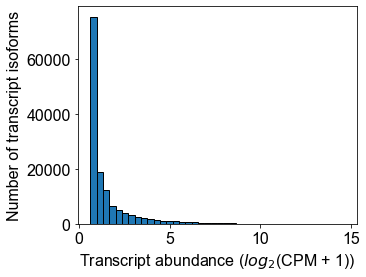

<Figure size 432x288 with 0 Axes>

In [6]:
def plot_figS1p1_right(sqanti_info, cpm_threshold):
    # transcriptional abundance for all transcript isoforms
    # note - only for cpm of 1 or higher
    sqanti_info_cpm = sqanti_info[sqanti_info.cpm > cpm_threshold]
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.hist(sqanti_info_cpm.log2cpm, bins=40, edgecolor='black')
    plt.xlabel('Transcript abundance ($log_2$(CPM + 1))')
    plt.ylabel('Number of transcript isoforms')
    plt.savefig(f'plot/FigS1.1_transcript_abund_all_data_min{cpm_threshold}cpm.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
    (sqanti_info_cpm
        .filter(items=['pb_acc', 'log2cpm'])
        .rename(columns={'log2cpm': 'log2cpm+1',
                        'pb_acc': 'pb_acc'})
        .to_csv(f'stats/FigS1.1_transcript_abund_all_data_min{cpm_threshold}cpm.tsv', sep='\t', index=None)
    )
plot_figS1p1_right(sqanti_info, cpm_threshold=0)

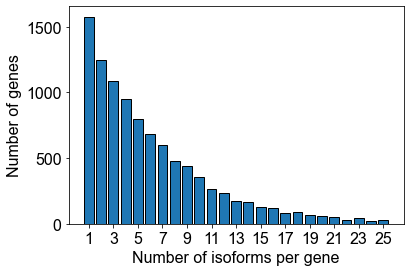

<Figure size 432x288 with 0 Axes>

In [19]:
def plot_S1p2(sqanti_info, cpm_threshold, max_isoforms_per_gene):
    # plot the distribution of isoform number per gene
    
    over_N_cpm = sqanti_info[sqanti_info['cpm'] > cpm_threshold]
    over_N_genes = over_N_cpm.groupby('gene').size().reset_index()
    over_N_genes.columns = ['gene', 'num_transcripts']
    max_t = over_N_genes['num_transcripts'].max()
    over_group = over_N_genes.groupby("num_transcripts").size()
    for i in range(1, max_t):
        if i not in over_group.index:
            over_group.at[i] = 0
    over_group = over_group.reset_index().sort_values(by = 'num_transcripts')
    fig, ax = plt.subplots(figsize=(6,4))
    plt.bar(range(1, max_isoforms_per_gene+1), over_group[0][:max_isoforms_per_gene], edgecolor='black')
    plt.xticks(range(1, max_isoforms_per_gene+1, 2))
    plt.xlabel('Number of isoforms per gene')
    plt.ylabel("Number of genes")
    plt.savefig('plot/FigS1.2_hist_num_iso_per_gene_min1cpm.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
    (over_group
        .rename(columns={'num_transcripts':'num_transcripts_per_gene',
                        0: 'num_genes'})
        .to_csv(f'stats/FigS1.2_hist_num_iso_per_gene_min{cpm_threshold}cpm__{max_isoforms_per_gene}.tsv', sep='\t', index=None)
    )
plot_S1p2(sqanti_info, cpm_threshold=1, max_isoforms_per_gene=25)

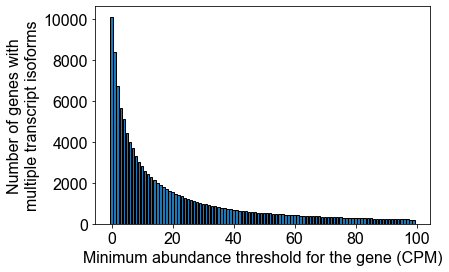

<Figure size 432x288 with 0 Axes>

In [18]:
def plot_S1p2_right(sqanti_info, transcript_cpm_threshold):
    sqanti_info = sqanti_info[sqanti_info['cpm'] > transcript_cpm_threshold]
    # number of multi-isoform genes when considering isoforms at diff. cpm thresholds
    with open('stats/FigS1.2_number_of_genes_with_multi_isoforms_at_diff_cpm_thresh.tsv', 'w') as ofile:
        ofile.write('cpm_threshold\tnum_genes_w_multi_isoforms\tpercent\n')
        info = sqanti_info.groupby('gene')['cpm'].agg(['size','sum']).reset_index().rename(columns = {'size': 'num_transcripts', 'sum':'cpm'})
        for cpm_threshold in range(0, 100, 1):
            over_N_genes = info[info['cpm'] >= cpm_threshold]
            num_genes = len(over_N_genes[over_N_genes['num_transcripts'] > 1])
            percent = round(num_genes / len(over_N_genes) * 100, 2)
            ofile.write('{}\t{}\t{}%\n'.format(cpm_threshold, num_genes, percent))
    # plot number of multi-isoform genes at different cpm thresholds
    multi_iso_genes = pd.read_table('stats/Fig_S1.2_number_of_genes_with_multi_isoforms_at_diff_cpm_thresh.tsv')
    fig = plt.figure(figsize=(6, 4))
    plt.bar(multi_iso_genes.cpm_threshold, multi_iso_genes.num_genes_w_multi_isoforms, width=0.8, edgecolor='black')
    plt.xlabel('Minimum abundance threshold for the gene (CPM)')
    plt.ylabel('Number of genes with\nmultiple transcript isoforms')
    plt.savefig('plot/FigS1.2_bar_multi_iso_gene_per_cpm_threshold.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
plot_S1p2_right(sqanti_info, 1)

In [11]:
sqanti_info.groupby('gene')['cpm'].agg(['size','sum']).reset_index().rename(columns = {'size': 'num_transcripts', 'sum':'cpm'})

,gene,num_transcripts,cpm
0,A1BG,2,1.090173
1,AAAS,14,108.472255
2,AACS,13,49.875434
3,AADAT,3,2.725434
4,AAGAB,18,268.182662
...,...,...,...
11181,ZXDC,13,22.348555
11182,ZYG11B,7,7.358671
11183,ZYX,2,9.539017
11184,ZZEF1,7,4.360694
